In [1]:
import math
import os

import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from tqdm import tqdm 

plt.ion()
from IPython.display import clear_output



In [2]:
class Hyperparameters(object):
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

hp = Hyperparameters(n_epochs=200,
                 batch_size=64,
                 lr=.0002,
                 b1=.5,
                 b2=0.999,
                 n_cpu=8,
                 latent_dim=100,
                 img_size=32,
                 channels=1,
                 sample_interval=400,
                    manual_seed=0,
                    width_mult = 2)

print(hp.lr)

0.0002


In [3]:
os.makedirs("images", exist_ok=True)

cuda = True if torch.cuda.is_available() else False

#Set random seed here
torch.manual_seed(hp.manual_seed)



def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, x, y, iter_num):
    with torch.no_grad():  
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = make_grid(images, x, y).numpy()
        figure(figsize=(20,20))
        img = np.transpose(np_imagegrid, (1, 2, 0))
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.tight_layout()
        plt.savefig(f"./images/{iter_num}.png")
        plt.show()
        

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        

        self.init_size = hp.img_size // 4
        self.l1 = nn.Sequential(nn.Linear(hp.latent_dim, 128 * hp.width_mult * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
          nn.BatchNorm2d(128*hp.width_mult),
          nn.Upsample(scale_factor=2),
          nn.Conv2d(128*hp.width_mult, 128*hp.width_mult, 3, stride=1, padding=1),
          nn.BatchNorm2d(128*hp.width_mult, 0.8),
          nn.LeakyReLU(0.2, inplace=True),
          nn.Upsample(scale_factor=2),
          nn.Conv2d(128*hp.width_mult, 64*hp.width_mult, 3, stride=1, padding=1),
          nn.BatchNorm2d(64*hp.width_mult, 0.8),
          nn.LeakyReLU(0.2, inplace=True),
          nn.Conv2d(64*hp.width_mult, hp.channels, 3, stride=1, padding=1),
          nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128*hp.width_mult, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), #kernel size, stride, padding
                    nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
          *discriminator_block(hp.channels, 16*hp.width_mult, bn=False),
          *discriminator_block(16*hp.width_mult, 32*hp.width_mult),
          *discriminator_block(32*hp.width_mult, 64*hp.width_mult),
          *discriminator_block(64*hp.width_mult, 128*hp.width_mult),
        )

        # The height and width of downsampled image
        ds_size = hp.img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * hp.width_mult * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [6]:
loss_fn = torch.nn.BCELoss()

generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    loss_fn.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (adv_l

In [7]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=hp.lr, betas=(hp.b1, hp.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [8]:
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
  datasets.FashionMNIST(
    "../../data/mnist",
    train=True,
    download=True,
    transform=transforms.Compose(
        [transforms.Resize(hp.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
    ),
  ),
  batch_size=hp.batch_size,
  shuffle=True,
)

Epoch:37:It94:DLoss0.4958115220069885:GLoss0.8131303191184998


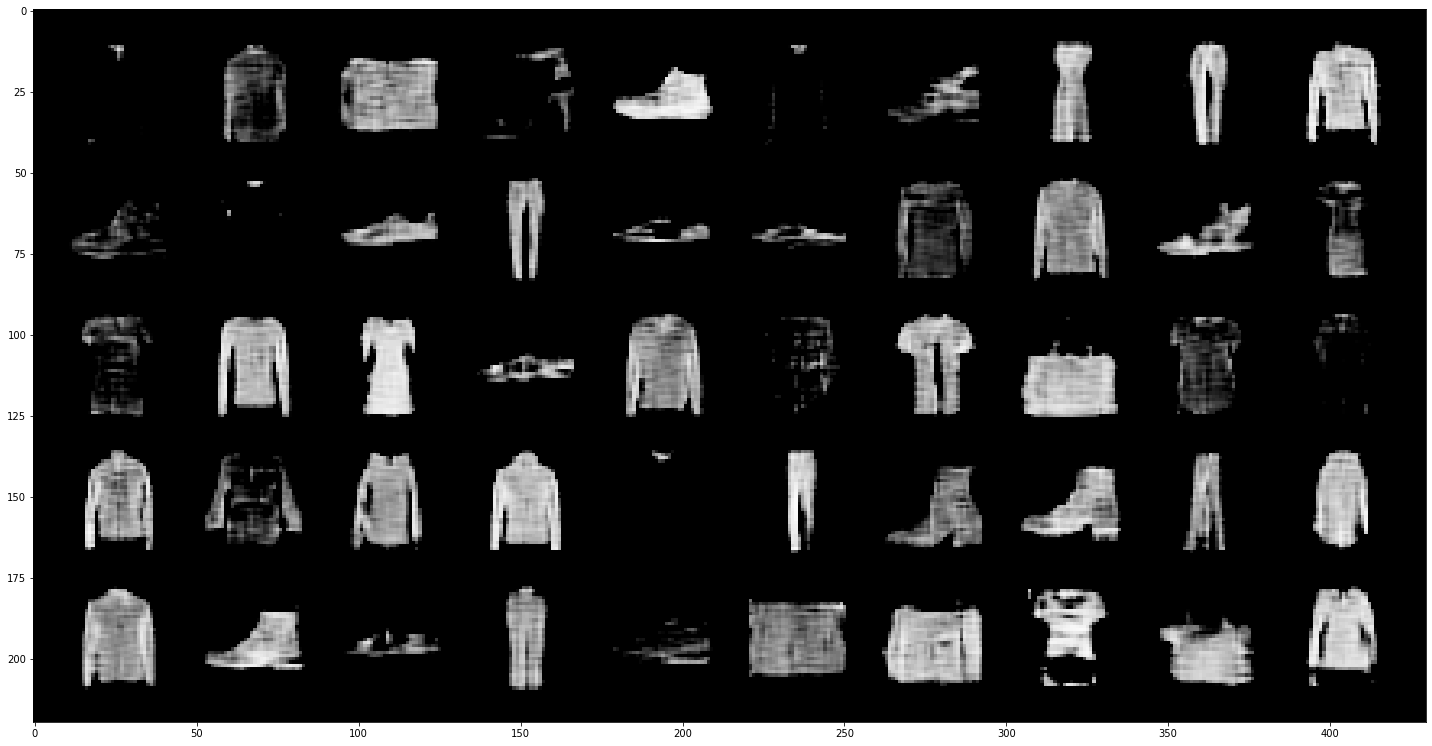

In [ ]:
CHECKPOINT_DIR = f"./weights/seed_{hp.manual_seed}/widthmult_{hp.width_mult}"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

g_losses = []  #record generator losses
d_losses = []  #record discriminator losses

for epoch in range(hp.n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], hp.latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = loss_fn(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = loss_fn(discriminator(real_imgs), valid)
        fake_loss = loss_fn(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        
        g_losses.append(g_loss.cpu().item())
        d_losses.append(d_loss.cpu().item())


        batches_done = epoch * len(dataloader) + i
        if batches_done % hp.sample_interval == 0:
            clear_output()
            print(f"Epoch:{epoch}:It{i}:DLoss{d_loss.item()}:GLoss{g_loss.item()}")          
            visualise_output(gen_imgs.data[:50],10, 10, f"{epoch}_{i}")
            #save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f"DCGAN_EPOCH_{epoch}.pt")
    torch.save(generator.state_dict(), checkpoint_path)

In [32]:
g_losses_np = np.array(g_losses)
d_losses_np = np.array(d_losses)

In [45]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

g_losses_avg = moving_average(g_losses_np, 1000)
d_losses_avg = moving_average(d_losses_np, 1000)

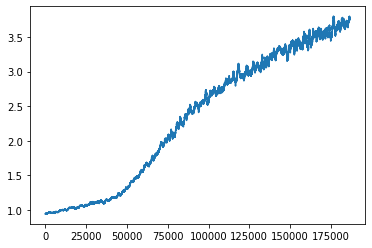

In [46]:
plt.plot(g_losses_avg)

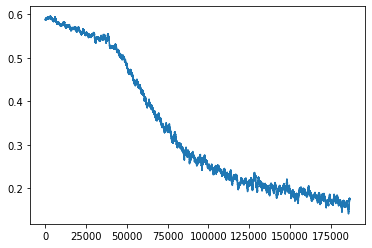

In [47]:
plt.plot(d_losses_avg)

In [48]:
generator

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)